In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
visit_df=pd.read_csv('../pcms_hackathon_data/train/visit.csv')
risk_df=pd.read_csv('../pcms_hackathon_data/train/risk.csv')

In [3]:
visit_df['visit_start_dt'] = pd.to_datetime(visit_df['visit_start_dt'], errors='coerce')
visit_df['visit_end_dt'] = pd.to_datetime(visit_df['visit_end_dt'], errors='coerce')

In [4]:
visit_type_dummies = pd.get_dummies(visit_df['visit_type'], prefix='visit_type')
visit_df = pd.concat([visit_df, visit_type_dummies], axis=1)

In [5]:
visit_final = (
    visit_df.groupby('patient_id')
    .agg({
        'visit_id': 'count',                
        'visit_type_ER': 'sum',
        'visit_type_URGENT CARE': 'sum',
        'visit_type_INPATIENT': 'sum',
        'readmsn_ind': 'sum',               
        'visit_start_dt': 'min',            
        'visit_end_dt': 'max'               
    })
    .reset_index()
)

In [6]:
visit_final.rename(columns={
    'visit_id': 'num_visits',
    'visit_type_ER': 'num_er_visits',
    'visit_type_URGENT CARE': 'num_urgent_visits',
    'visit_type_INPATIENT': 'num_inpatient_visits',
    'readmsn_ind': 'num_readmissions',
    'visit_start_dt': 'first_visit_dt',
    'visit_end_dt': 'last_visit_dt'
}, inplace=True)

In [7]:
visit_final['days_between_first_last_visit'] = (
    (visit_final['last_visit_dt'] - visit_final['first_visit_dt']).dt.days
).replace([np.inf, np.nan], 0)

In [8]:
merged_visit_risk = risk_df.merge(visit_final, on='patient_id', how='left')

In [9]:
merged_visit_risk.fillna({
    'num_visits': 0,
    'num_er_visits': 0,
    'num_urgent_visits': 0,
    'num_inpatient_visits': 0,
    'num_readmissions': 0,
    'days_between_first_last_visit': 0
}, inplace=True)

In [10]:
corr_matrix = merged_visit_risk.corr(numeric_only=True)

# Extract correlations with risk_score
risk_corr = corr_matrix['risk_score'].sort_values(ascending=False)
print("Correlation with risk_score:")
print(risk_corr)

Correlation with risk_score:
risk_score                       1.000000
num_inpatient_visits             0.445725
num_visits                       0.285180
num_er_visits                    0.269558
days_between_first_last_visit    0.215651
num_urgent_visits                0.055915
patient_id                      -0.016482
Name: risk_score, dtype: float64


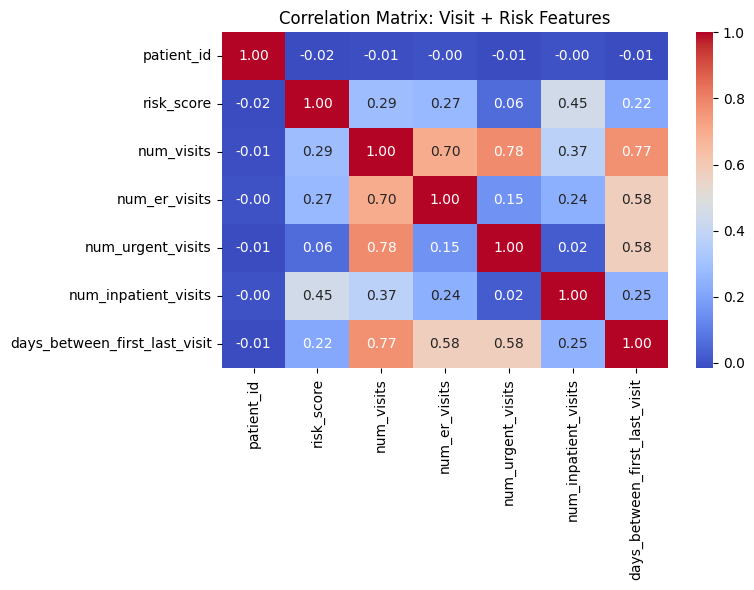

In [11]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Visit + Risk Features")
plt.tight_layout()
plt.show()

In [12]:
output_path = "risk_visit.csv"
merged_visit_risk.to_csv(output_path, index=False)
print(f"File saved successfully: {output_path}")

File saved successfully: risk_visit.csv
